## DSGA 1001 - Tree Analysis (Prediction)
### December 15, 2022
Code by: Christine Gao and Fiona Chow


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [84]:
rng = random.seed(18962882)
# import importlib
# importlib.reload(plt); importlib.reload(plt); importlib.reload(sns)

In [3]:
# import geopandas as gpd
# from dbfread import DBF

## EDA and Visualizations

In [4]:
## Primary data set - NYC Street Tree Census from 2015
census = pd.read_csv('new_york_tree_census_2015.csv')
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 41 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   tree_id     683788 non-null  int64  
 1   block_id    683788 non-null  int64  
 2   created_at  683788 non-null  object 
 3   tree_dbh    683788 non-null  int64  
 4   stump_diam  683788 non-null  int64  
 5   curb_loc    683788 non-null  object 
 6   status      683788 non-null  object 
 7   health      652172 non-null  object 
 8   spc_latin   652169 non-null  object 
 9   spc_common  652169 non-null  object 
 10  steward     652173 non-null  object 
 11  guards      652172 non-null  object 
 12  sidewalk    652172 non-null  object 
 13  user_type   683788 non-null  object 
 14  problems    652124 non-null  object 
 15  root_stone  683788 non-null  object 
 16  root_grate  683788 non-null  object 
 17  root_other  683788 non-null  object 
 18  trunk_wire  683788 non-null  object 
 19  tr

<AxesSubplot:xlabel='guards', ylabel='count'>

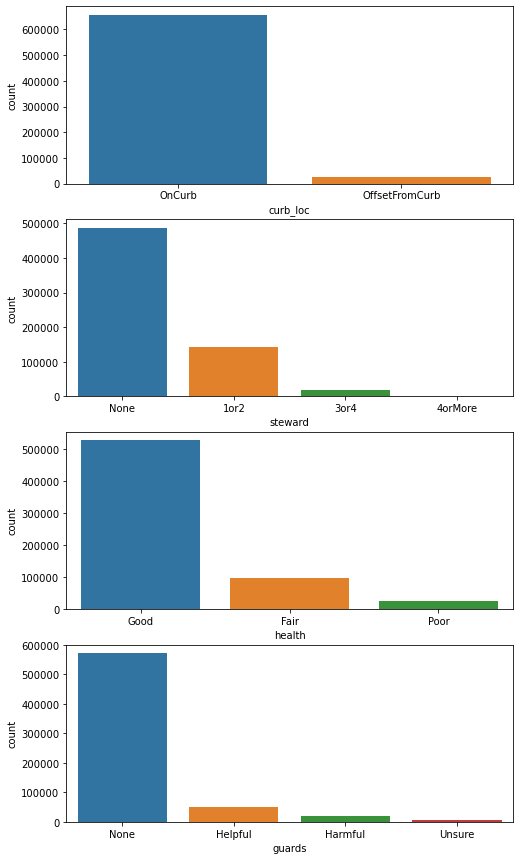

In [5]:
#categorical_features = ['spc_common', 'curb_loc', 'steward', 'health']
fig, axs = plt.subplots(nrows = 4,  figsize=(8,15))

sns.countplot(x=census['curb_loc'], ax=axs[0])
sns.countplot(x=census['steward'], ax=axs[1])
sns.countplot(x=census['health'], ax=axs[2])
sns.countplot(x=census['guards'], ax=axs[3])

In [6]:
## NYC NTA with corrosponding codes and neighborhood areas
nta = pd.read_csv('nynta.csv')
nta.head()

,the_geom,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.94732672160586 40.62916656...,3,Brooklyn,47,BK43,Midwood,"27,996.5912736","35,799,637.8103"
1,MULTIPOLYGON (((-73.94193078816201 40.70072523...,3,Brooklyn,47,BK75,Bedford,"29,992.9191744","32,629,833.1149"
2,MULTIPOLYGON (((-73.89138023380268 40.86170058...,2,Bronx,5,BX40,Fordham South,"15,878.2729212","6,307,283.62202"
3,MULTIPOLYGON (((-73.9760493559142 40.631275905...,3,Brooklyn,47,BK88,Borough Park,"39,247.227722","54,005,019.2286"
4,MULTIPOLYGON (((-73.90855790522774 40.65209593...,3,Brooklyn,47,BK96,Rugby-Remsen Village,"30,957.8533949","32,706,946.4035"


In [7]:
nta = nta.rename(columns={'NTACode': "nta"})

In [8]:
#df = census merged on nta
df = pd.merge(census, nta, on='nta')
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,longitude,x_sp,y_sp,the_geom,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area
0,606945,305778,2016-06-28,10,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,-73.805180,1038250.055,203232.9417,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
1,679996,307398,2016-08-25,4,0,OnCurb,Alive,Good,Quercus palustris,pin oak,...,-73.823070,1033288.667,204501.9562,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
2,680506,307388,2016-08-25,4,0,OnCurb,Alive,Good,Carpinus betulus,European hornbeam,...,-73.819915,1034165.471,203462.1729,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
3,691878,305754,2016-09-01,17,0,OffsetFromCurb,Alive,Good,Quercus phellos,willow oak,...,-73.813822,1035854.144,203506.7804,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
4,692503,307786,2016-09-01,15,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,-73.822124,1033558.531,200722.5845,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"


/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tree_dbh'>

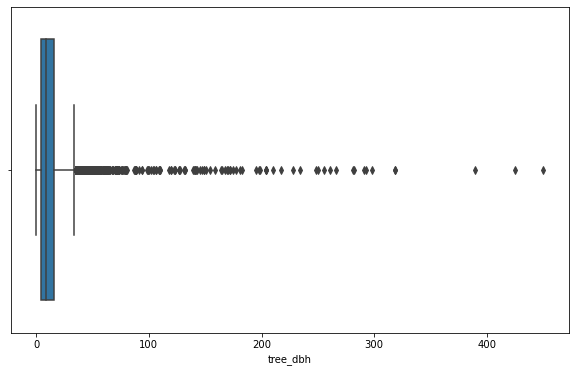

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(df['tree_dbh'])

##observe outliers in the tree diameter - we will normalize this

## Data Cleaning / Preprocessing

For our analysis, we will investigate only the live trees.

In [10]:
## Removal of dead trees and stumps 
df1 = df[df["status"].str.contains("Dead|Stump")==False]
df1.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,longitude,x_sp,y_sp,the_geom,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area
0,606945,305778,2016-06-28,10,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,-73.805180,1038250.055,203232.9417,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
1,679996,307398,2016-08-25,4,0,OnCurb,Alive,Good,Quercus palustris,pin oak,...,-73.823070,1033288.667,204501.9562,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
2,680506,307388,2016-08-25,4,0,OnCurb,Alive,Good,Carpinus betulus,European hornbeam,...,-73.819915,1034165.471,203462.1729,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
3,691878,305754,2016-09-01,17,0,OffsetFromCurb,Alive,Good,Quercus phellos,willow oak,...,-73.813822,1035854.144,203506.7804,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"
4,692503,307786,2016-09-01,15,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,-73.822124,1033558.531,200722.5845,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813"


(array([6.50597e+05, 1.49400e+03, 3.10000e+01, 2.10000e+01, 1.30000e+01,
        5.00000e+00, 7.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([  0. ,  42.5,  85. , 127.5, 170. , 212.5, 255. , 297.5, 340. ,
        382.5, 425. ]),
 <BarContainer object of 10 artists>)

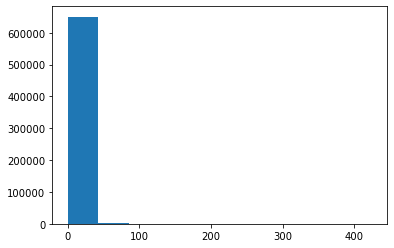

In [11]:
plt.figure(figsize=(6,4))
plt.hist(df1['tree_dbh'])

In [12]:
lower = df1['tree_dbh'].quantile(0.01)
upper = df1['tree_dbh'].quantile(0.99)

df2 = df1[(df1['tree_dbh'] < upper) & (df1['tree_dbh'] > lower)]

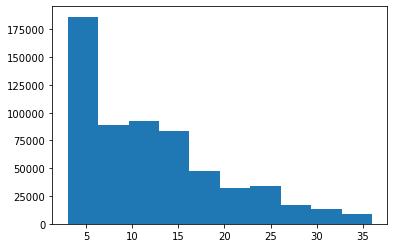

In [13]:
## New histogram omitting outliers within a 98% range
plt.figure(figsize=(6,4))

plt.hist(df2['tree_dbh'])
census_clean=df2

In [14]:
# calculating tree counts by nta 
tree_nta = pd.DataFrame(census_clean.groupby('nta')['tree_id'].count())
tree_nta1 = tree_nta.reset_index()
tree_nta2 = tree_nta1.rename(columns={'tree_id':'tree counts'})
tree_nta_density = pd.merge(census_clean, tree_nta2, on='nta')
tree_nta_density.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,x_sp,y_sp,the_geom,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area,tree counts
0,606945,305778,2016-06-28,10,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,1038250.055,203232.9417,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813",4497
1,679996,307398,2016-08-25,4,0,OnCurb,Alive,Good,Quercus palustris,pin oak,...,1033288.667,204501.9562,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813",4497
2,680506,307388,2016-08-25,4,0,OnCurb,Alive,Good,Carpinus betulus,European hornbeam,...,1034165.471,203462.1729,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813",4497
3,691878,305754,2016-09-01,17,0,OffsetFromCurb,Alive,Good,Quercus phellos,willow oak,...,1035854.144,203506.7804,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813",4497
4,692503,307786,2016-09-01,15,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,1033558.531,200722.5845,MULTIPOLYGON (((-73.81497208257481 40.73856071...,4,Queens,81,Kew Gardens Hills,"33,109.3220103","37,891,124.4813",4497


In [15]:
tree_nta_density['Shape_Area'] = census_clean['Shape_Area'].apply(lambda x: float(x.split()[0].replace(',', '')))
tree_nta_density['tree density'] = tree_nta_density['tree counts']/tree_nta_density['Shape_Area']
##tree_nta_density_final - contains tree density (tree count per nta divided by area of each nta)

In [16]:
tree_nta_density_final = tree_nta_density[['tree_id', 'health', 'status', 'tree_dbh', 'nta', 'Shape_Area', 'tree counts', 'tree density']]
tree_nta_density_final

,tree_id,health,status,tree_dbh,nta,Shape_Area,tree counts,tree density
0,606945,Good,Alive,10,QN37,3.789112e+07,4497,0.000119
1,679996,Good,Alive,4,QN37,3.789112e+07,4497,0.000119
2,680506,Good,Alive,4,QN37,3.789112e+07,4497,0.000119
3,691878,Good,Alive,17,QN37,3.789112e+07,4497,0.000119
4,692503,Good,Alive,15,QN37,3.789112e+07,4497,0.000119
...,...,...,...,...,...,...,...,...
604171,72105,Good,Alive,3,BK23,1.665074e+07,418,0.000025
604172,374586,Good,Alive,7,BK23,1.665074e+07,418,0.000025
604173,70230,Good,Alive,12,BK23,1.665074e+07,418,0.000025
604174,442173,Good,Alive,12,BK23,1.665074e+07,418,0.000025


## NY NTA 2020 Census Data

In [17]:
xls = pd.ExcelFile('demo_2015acs5yr_nta.xlsx')
xls1 = pd.ExcelFile('econ_2015acs5yr_nta.xlsx')
xls2 = pd.ExcelFile('hous_2015acs5yr_nta.xlsx')
xls3 = pd.ExcelFile('soc_2015acs5yr_nta.xlsx')

In [18]:
demdata = pd.read_excel(xls, 'DemData')
econdata = pd.read_excel(xls1, 'EconData')
housdata = pd.read_excel(xls2, 'HousData')
socdata = pd.read_excel(xls3, 'SocData')

In [19]:
dem = demdata[['GeoID', 'Pop_1E', 'BlNHP','NHspP']]
dem = dem.rename(columns={'GeoID':'nta', 'Pop_1E':'Total Population', 'BlNHP':'Percent Black/African American','NHspP':'Percent Hispanic'})
# dem['Percent Hispanic/Black'] = dem['Percent Black/African American']+dem['Percent Hispanic']

In [20]:
soc = socdata[['GeoID', 'EA_LTHSGrE', 'EA_LTHSGrP', 'EA_BchDHE', 'EA_BchDHP']]
soc = soc.rename(columns={'GeoID':'nta', 'EA_LTHSGrE': "Less than HS Grad Estimate", "EA_LTHSGrP": "Less than HS Grad Percent", 
                   'EA_BchDHE': 'Bachelor or Higher Estimate', 'EA_BchDHP':'Bachelor or Higher Percent'})

In [21]:
econ = econdata[['GeoID', 'MdHHIncE']]
econ = econ.rename(columns={'GeoID':'nta', 'MdHHIncE':'Median HH Income Estimate'})

In [22]:
hous = housdata[['GeoID', 'Borough', 'MdVlE', 'OcHU1P']]
hous = hous.rename(columns={'GeoID':'nta', 'MdVlE':'Median House Value Estimate', 'OcHU1P':'Percent Occupied Units'})

In [23]:
nta_df0 = pd.merge(dem, econ, on='nta')
nta_df = pd.merge(nta_df0, soc, on='nta')
nta_df1 = pd.merge(nta_df, hous, on='nta')

In [24]:
nta_df1

,nta,Total Population,Percent Black/African American,Percent Hispanic,Median HH Income Estimate,Less than HS Grad Estimate,Less than HS Grad Percent,Bachelor or Higher Estimate,Bachelor or Higher Percent,Borough,Median House Value Estimate,Percent Occupied Units
0,BK27,33072,2.0,83.0,55681.0,5461,23.3,7597,32.4,Brooklyn,647778.0,94.2
1,BK31,82560,1.8,82.4,61389.0,8157,13.6,27234,45.4,Brooklyn,644029.0,91.8
2,BK75,73125,43.5,81.3,36737.0,9494,22.2,12300,28.8,Brooklyn,654007.0,87.7
3,BK29,63882,0.7,88.7,48508.0,12368,26.8,13256,28.7,Brooklyn,630095.0,93.5
4,BK28,92433,0.9,85.2,48812.0,19049,29.0,16407,25.0,Brooklyn,676633.0,93.7
...,...,...,...,...,...,...,...,...,...,...,...,...
190,BX63,37510,24.0,30.2,25893.0,8129,36.0,3116,13.8,The Bronx,249073.0,94.7
191,BX08,36493,24.9,34.2,28884.0,8847,38.2,2489,10.7,The Bronx,426773.0,91.1
192,BX59,27830,16.2,38.0,42528.0,4482,25.5,3166,18.0,The Bronx,419169.0,92.7
193,BX44,63712,68.8,75.5,39808.0,8659,21.5,7206,17.9,The Bronx,377741.0,92.5


In [25]:
master = pd.merge(tree_nta_density_final[['nta', 'Shape_Area']], nta_df1, on='nta')

master['Population Density'] = master['Total Population']/master['Shape_Area']

In [26]:
master.head()

,nta,Shape_Area,Total Population,Percent Black/African American,Percent Hispanic,Median HH Income Estimate,Less than HS Grad Estimate,Less than HS Grad Percent,Bachelor or Higher Estimate,Bachelor or Higher Percent,Borough,Median House Value Estimate,Percent Occupied Units,Population Density
0,QN37,3.789112e+07,39267,7.2,88.4,62840.0,2967,11.6,10750,42.1,Queens,309396.0,93.3,0.001036
1,QN37,3.789112e+07,39267,7.2,88.4,62840.0,2967,11.6,10750,42.1,Queens,309396.0,93.3,0.001036
2,QN37,3.789112e+07,39267,7.2,88.4,62840.0,2967,11.6,10750,42.1,Queens,309396.0,93.3,0.001036
3,QN37,3.789112e+07,39267,7.2,88.4,62840.0,2967,11.6,10750,42.1,Queens,309396.0,93.3,0.001036
4,QN37,3.789112e+07,39267,7.2,88.4,62840.0,2967,11.6,10750,42.1,Queens,309396.0,93.3,0.001036


In [27]:
master1 = master[['nta', 'Population Density', 'Percent Black/African American', 'Less than HS Grad Estimate',
                  'Less than HS Grad Percent', 'Bachelor or Higher Estimate', 'Bachelor or Higher Percent', 
                  'Median HH Income Estimate', 'Borough', 'Median House Value Estimate', 'Percent Occupied Units']]
master2 = master1.groupby('nta').mean()
master2 = master2.reset_index()

In [28]:
master2

,nta,Population Density,Percent Black/African American,Less than HS Grad Estimate,Less than HS Grad Percent,Bachelor or Higher Estimate,Bachelor or Higher Percent,Median HH Income Estimate,Median House Value Estimate,Percent Occupied Units
0,BK09,0.000281,5.4,468.0,2.5,14302.0,77.3,102850.0,732992.0,87.9
1,BK17,0.001512,6.9,6482.0,13.8,18509.0,39.3,51203.0,472474.0,91.5
2,BK19,0.000934,1.0,3131.0,12.5,10431.0,41.8,33934.0,542894.0,88.9
3,BK21,0.000529,30.5,5877.0,30.0,4324.0,22.0,23005.0,421143.0,89.4
4,BK23,0.000468,0.6,771.0,5.7,6386.0,47.6,38805.0,274360.0,92.5
...,...,...,...,...,...,...,...,...,...,...
183,SI36,0.000542,3.9,2147.0,12.2,5072.0,28.9,64592.0,435556.0,91.4
184,SI37,0.000658,19.6,3266.0,18.4,4454.0,25.1,55408.0,365025.0,89.7
185,SI45,0.000248,1.0,1392.0,9.5,4582.0,31.1,74432.0,429999.0,91.6
186,SI48,0.000719,1.9,1539.0,8.4,6094.0,33.4,83032.0,420163.0,97.4


In [29]:
demo_tree_nta = tree_nta_density_final.merge(master2, on='nta')
demo_tree_nta = demo_tree_nta.dropna()
tree_demo_avg = demo_tree_nta.groupby('nta').mean()

(array([91., 22., 19., 18.,  5.,  5.,  5.,  9.,  3., 10.]),
 array([ 0.1 ,  9.11, 18.12, 27.13, 36.14, 45.15, 54.16, 63.17, 72.18,
        81.19, 90.2 ]),
 <BarContainer object of 10 artists>)

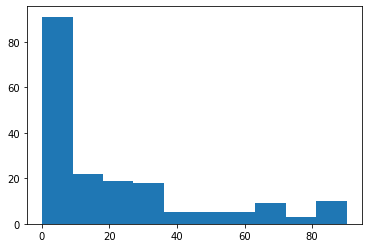

In [30]:
plt.hist(tree_demo_avg['Percent Black/African American'])

(array([25., 34., 46., 28., 18.,  9.,  6.,  5.,  6., 10.]),
 array([ 7.4 , 15.15, 22.9 , 30.65, 38.4 , 46.15, 53.9 , 61.65, 69.4 ,
        77.15, 84.9 ]),
 <BarContainer object of 10 artists>)

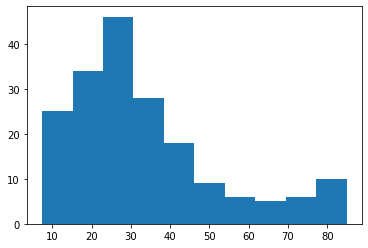

In [31]:
plt.hist(tree_demo_avg['Bachelor or Higher Percent'])

(array([31., 42., 45., 32., 22.,  5.,  5.,  4.,  0.,  1.]),
 array([ 20314. ,  34314.9,  48315.8,  62316.7,  76317.6,  90318.5,
        104319.4, 118320.3, 132321.2, 146322.1, 160323. ]),
 <BarContainer object of 10 artists>)

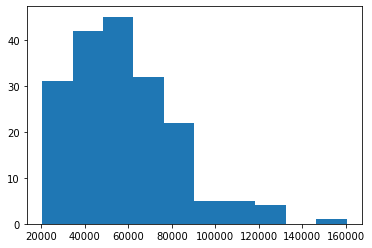

In [32]:
plt.hist(tree_demo_avg['Median HH Income Estimate'])

(array([ 6., 69., 63., 37.,  7.,  3.,  0.,  0.,  0.,  2.]),
 array([  37572. ,  233814.8,  430057.6,  626300.4,  822543.2, 1018786. ,
        1215028.8, 1411271.6, 1607514.4, 1803757.2, 2000000. ]),
 <BarContainer object of 10 artists>)

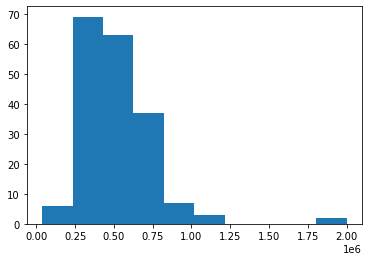

In [33]:
plt.hist(tree_demo_avg['Median House Value Estimate'])

(array([49., 73., 26., 17.,  7.,  7.,  2.,  3.,  2.,  1.]),
 array([6.93490465e-05, 6.28325293e-04, 1.18730154e-03, 1.74627778e-03,
        2.30525403e-03, 2.86423028e-03, 3.42320652e-03, 3.98218277e-03,
        4.54115901e-03, 5.10013526e-03, 5.65911151e-03]),
 <BarContainer object of 10 artists>)

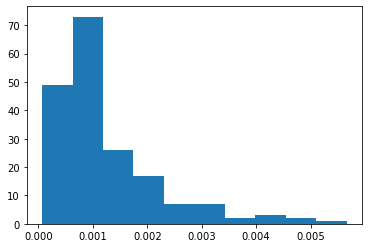

In [34]:
plt.hist(tree_demo_avg['Population Density'])

(array([ 1.,  0.,  3.,  2.,  4.,  8., 16., 62., 77., 14.]),
 array([71. , 73.7, 76.4, 79.1, 81.8, 84.5, 87.2, 89.9, 92.6, 95.3, 98. ]),
 <BarContainer object of 10 artists>)

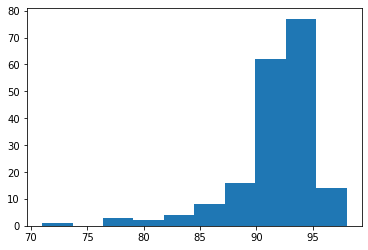

In [35]:
plt.hist(tree_demo_avg['Percent Occupied Units'])

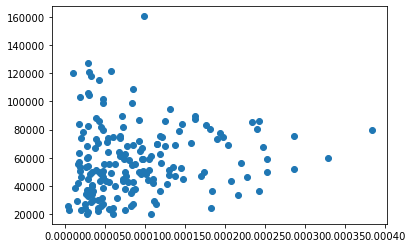

In [36]:
plt.scatter(tree_demo_avg['tree density'], tree_demo_avg['Median HH Income Estimate'])

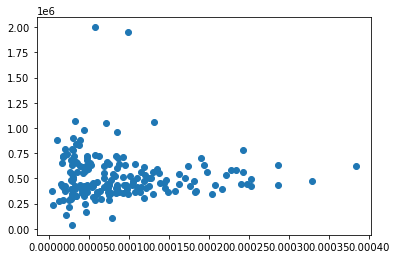

In [37]:
plt.scatter(tree_demo_avg['tree density'], tree_demo_avg['Median House Value Estimate'])

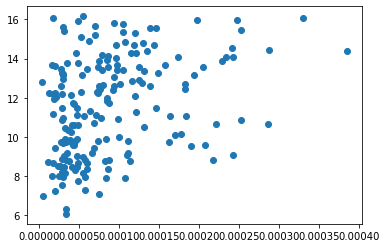

In [38]:
plt.scatter(tree_demo_avg['tree density'], tree_demo_avg['tree_dbh'])

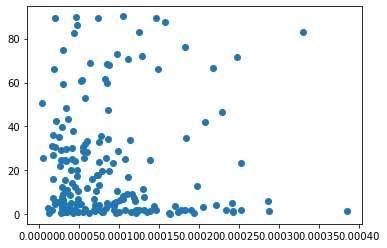

In [39]:
plt.scatter(tree_demo_avg['tree density'], tree_demo_avg['Percent Black/African American'])

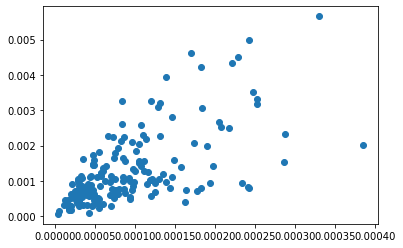

In [40]:
plt.scatter(tree_demo_avg['tree density'],tree_demo_avg['Population Density'])

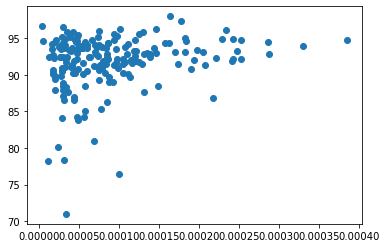

In [41]:
plt.scatter(tree_demo_avg['tree density'], tree_demo_avg['Percent Occupied Units'])

In [42]:
tree_demo_avg[['tree_dbh', 'tree density', 'Population Density', 'Percent Black/African American', 
               'Less than HS Grad Percent', 'Bachelor or Higher Percent', 'Percent Occupied Units', 
               'Median HH Income Estimate', 'Median House Value Estimate']].corr()

,tree_dbh,tree density,Population Density,Percent Black/African American,Less than HS Grad Percent,Bachelor or Higher Percent,Percent Occupied Units,Median HH Income Estimate,Median House Value Estimate
tree_dbh,1.000000,0.332296,0.075626,0.006995,-0.290163,-0.050639,0.336681,0.113424,-0.111216
tree density,0.332296,1.000000,0.640104,0.000828,-0.120107,-0.117236,0.221792,0.116979,-0.013209
Population Density,0.075626,0.640104,1.000000,0.119288,0.228026,-0.152865,0.077170,-0.167298,0.012580
Percent Black/African American,0.006995,0.000828,0.119288,1.000000,0.126127,-0.380058,0.059561,-0.290050,-0.291447
Less than HS Grad Percent,-0.290163,-0.120107,0.228026,0.126127,1.000000,-0.761540,0.281750,-0.812477,-0.380288
Bachelor or Higher Percent,-0.050639,-0.117236,-0.152865,-0.380058,-0.761540,1.000000,-0.484690,0.807972,0.654272
Percent Occupied Units,0.336681,0.221792,0.077170,0.059561,0.281750,-0.484690,1.000000,-0.403530,-0.483705
Median HH Income Estimate,0.113424,0.116979,-0.167298,-0.290050,-0.812477,0.807972,-0.403530,1.000000,0.601673
Median House Value Estimate,-0.111216,-0.013209,0.012580,-0.291447,-0.380288,0.654272,-0.483705,0.601673,1.000000


In [43]:
tree_demo_avg

,tree_id,tree_dbh,Shape_Area,tree counts,tree density,Population Density,Percent Black/African American,Less than HS Grad Estimate,Less than HS Grad Percent,Bachelor or Higher Estimate,Bachelor or Higher Percent,Median HH Income Estimate,Median House Value Estimate,Percent Occupied Units
nta,,,,,,,,,,,,,,
BK09,120719.086586,12.268275,8.538518e+07,1655.0,0.000020,0.000281,5.4,468.0,2.5,14302.0,77.3,102850.0,732992.0,87.9
BK17,314681.361030,15.371963,4.383182e+07,4463.0,0.000105,0.001512,6.9,6482.0,13.8,18509.0,39.3,51203.0,472474.0,91.5
BK19,301621.384865,12.962162,3.579964e+07,1053.0,0.000029,0.000934,1.0,3131.0,12.5,10431.0,41.8,33934.0,542894.0,88.9
BK21,289929.227519,7.260022,5.543487e+07,1092.0,0.000020,0.000529,30.5,5877.0,30.0,4324.0,22.0,23005.0,421143.0,89.4
BK23,276938.002660,12.231383,1.092484e+08,418.0,0.000013,0.000468,0.6,771.0,5.7,6386.0,47.6,38805.0,274360.0,92.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI36,356144.454135,12.606488,5.806492e+07,4302.0,0.000094,0.000542,3.9,2147.0,12.2,5072.0,28.9,64592.0,435556.0,91.4
SI37,330171.996945,8.852342,4.056957e+07,3479.0,0.000087,0.000658,19.6,3266.0,18.4,4454.0,25.1,55408.0,365025.0,89.7
SI45,369017.504339,16.155979,8.950481e+07,4593.0,0.000054,0.000248,1.0,1392.0,9.5,4582.0,31.1,74432.0,429999.0,91.6


In [44]:
features = tree_demo_avg[['tree_dbh', 'Population Density', 'Percent Black/African American','Bachelor or Higher Percent',
                         'Median HH Income Estimate', 'Percent Occupied Units','Median House Value Estimate']].to_numpy()

In [45]:
target = tree_demo_avg[['tree density']].to_numpy()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=18962882)

## Regression Model

In [94]:
regr = linear_model.LinearRegression()

In [95]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [96]:
print('MULTIPLE REGRESSION MODEL')
print()
print('Model Parameters or coefficient values for "a":')
print(regr.coef_)
print('Intercept or coefficient value for "b":')
print(regr.intercept_)
print()
print('MODEL ACCURACY:')
print(regr.score(X_train, y_train))
print()

MULTIPLE REGRESSION MODEL

Model Parameters or coefficient values for "a":
[[ 3.59080211e-06  4.86898758e-02 -3.08109951e-07 -1.85381757e-06
   1.75144031e-09  2.69060338e-06 -2.23458752e-12]]
Intercept or coefficient value for "b":
[-0.00029077]

MODEL ACCURACY:
0.6337470069544167



In [97]:
mean_squared_error(y_test,y_pred)

1.884929078144911e-09

In [98]:
r2_score(y_test, y_pred)

print(r2_score(y_test, y_pred))

0.6202335066129203


In [99]:
#calculate residual of all data

residuals_table_all = pd.DataFrame(target)
residuals_table_all = residuals_table_all.rename(columns={0:'target'})

residuals_table_all['Y_HAT'] = regr.predict(features).reshape((-1, 1))
residuals_table_all['Residuals'] = residuals_table_all['Y_HAT'] - residuals_table_all['target']

residuals_table_all.shape

(187, 3)

Text(0, 0.5, 'Residuals')

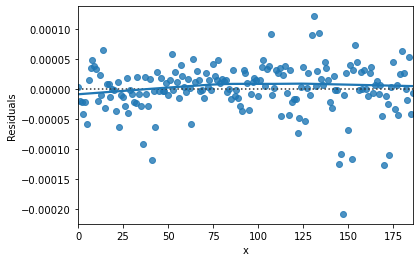

In [92]:
sns.residplot(x=np.arange(0,187,1),y=residuals_table_all['Residuals'],lowess=True)
plt.xlabel('x')
plt.ylabel('Residuals')

## Polyfit Model

In [110]:
poly = PolynomialFeatures(2, include_bias=False)
poly_features = poly.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(poly_features, target, test_size=0.2, random_state=18962882)

In [111]:
poly_reg_model = linear_model.LinearRegression()
poly_reg_model.fit(X_train, y_train)

LinearRegression()

In [112]:
poly_reg_y_predicted = poly_reg_model.predict(X_test)
poly_reg_mse = mean_squared_error(y_test, poly_reg_y_predicted)
print(poly_reg_mse)

2.833110528958655e-09


In [113]:
print(poly_reg_model.score(X_train, y_train))

0.796982916032543


In [114]:
print(r2_score(y_test, poly_reg_y_predicted))

0.42919844389077455
